## Model Definitions

In [2]:
!pip install -q numpy pandas torch matplotlib bluequbit pennylane pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 80.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.1 MB/s eta 0:00:00:00:01
   ━━━━━━

## Reuploaded data on state color Map

/usr/local/lib/python3.10/dist-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


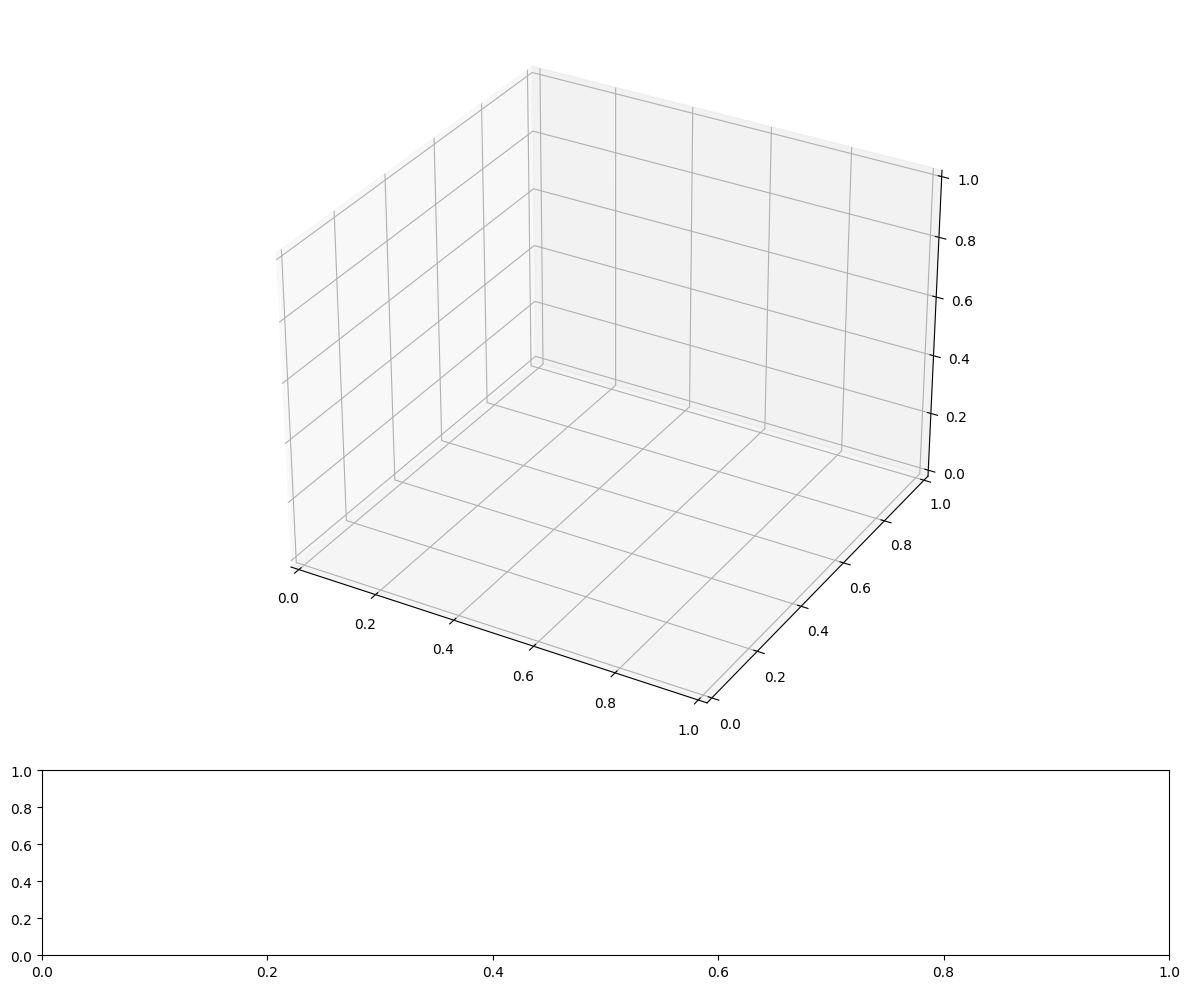

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/art3d.py:1203: RuntimeWarning: divide by zero encountered in divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


In [3]:
import numpy as np
import torch
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation

# --------------------------------------
# Define the QRU circuit
# --------------------------------------
def QRU(params, x, alpha=0.5, reuploads=3):
    for _ in range(reuploads):
        for i in range(depth):
            for j in range(len(x)):
                qml.RY(x[j], wires=0)
                qml.RX(params[i][2 * j], wires=0)
                qml.RY(params[i][2 * j + 1], wires=0)

# --------------------------------------
# Parameters and dataset
# --------------------------------------
n_input = 10      # Sliding window size
depth = 3         # Circuit depth
reuploads = 3     # Reuploads
np.random.seed(42)
time_series = np.random.rand(100)

# Generate sliding windows
windows = [time_series[i:i+n_input] for i in range(len(time_series) - n_input + 1)]

# Normalize each window
normalized_windows = [(w - np.min(w)) / (np.max(w) - np.min(w)) for w in windows]

# --------------------------------------
# Define Pennylane device and QNode
# --------------------------------------
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qru_circuit(params, x):
    QRU(params, x)
    return qml.density_matrix(wires=0)

params = torch.tensor(np.full((depth, 2 * n_input), 0.5), requires_grad=False, dtype=torch.float64)

# Compute final states for all windows
final_states = [qru_circuit(params, w).detach().numpy() for w in normalized_windows]

# --------------------------------------
# Create Spherical Grid for Bloch Sphere
# --------------------------------------
theta = np.linspace(0, 2 * np.pi, 60)   # azimuthal
phi = np.linspace(0, np.pi, 60)         # polar
Theta, Phi = np.meshgrid(theta, phi)

X = np.sin(Phi) * np.cos(Theta)
Y = np.sin(Phi) * np.sin(Theta)
Z = np.cos(Phi)

# --------------------------------------
# Plotting and Animation (with Time-Series)
# --------------------------------------
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1])
ax3d = fig.add_subplot(gs[0], projection='3d')  # Bloch sphere
ax2d = fig.add_subplot(gs[1])                   # Input time-series window

surf = [None]  # For holding the surface plot reference

def update(frame):
    ax3d.clear()
    ax2d.clear()

    final_state = final_states[frame]
    input_window = normalized_windows[frame]

    # Compute amplitude-modulated radius R
    R = np.zeros_like(Theta)
    for j in range(Theta.shape[0]):
        for k in range(Theta.shape[1]):
            angle = Theta[j, k]
            prob_amp = np.abs(
                final_state[0, 0] * np.exp(1j * angle) +
                final_state[1, 1] * np.exp(-1j * angle)
            )
            R[j, k] = prob_amp

    # Spherical to deformed Cartesian coordinates
    Xr = R * X
    Yr = R * Y
    Zr = R * Z

    # Plot Bloch Sphere final state
    surf[0] = ax3d.plot_surface(Xr, Yr, Zr, facecolors=cm.viridis(R / np.max(R)),
                                rstride=1, cstride=1, antialiased=True, alpha=0.9)
    ax3d.set_title(f"QRU Final State on Bloch Sphere\nTime Step: {frame}", fontsize=14)
    ax3d.set_xlabel('X (Real)')
    ax3d.set_ylabel('Y (Imag)')
    ax3d.set_zlabel('Z (Phase)')
    ax3d.set_box_aspect([1,1,1])
    ax3d.view_init(elev=30, azim=45)

    # Plot Input Window below
    ax2d.bar(range(len(input_window)), input_window, color='royalblue')
    ax2d.set_ylim(0, 1)
    ax2d.set_title(f"Normalized Input Time-Series Window at t={frame}", fontsize=12)
    ax2d.set_xlabel("Time Step (within window)")
    ax2d.set_ylabel("Normalized Value")

# Create animation
ani = FuncAnimation(fig, update, frames=len(final_states), interval=300, repeat=True)

# Show the animation
plt.tight_layout()
plt.show()

# Optional: Save animation
ani.save("qru_parallel_visualization.mp4", writer="ffmpeg", fps=10)

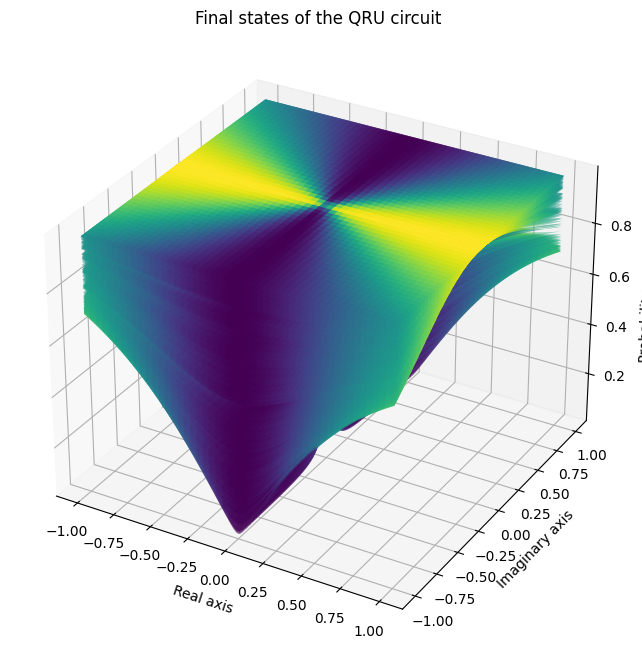

In [6]:
#old code
import numpy as np
import torch
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the QRU circuit
def QRU(params, x, alpha=0.5, reuploads=3):
    for _ in range(reuploads):
        for i in range(depth):
            for j in range(len(x)):
                qml.RY(x[j], wires=0)
                qml.RX(params[i][2 * j], wires=0)
                qml.RY(params[i][2 * j + 1], wires=0)

# Define the parameters and input data
n_input = 10  # Window size
depth = 3  # Circuit depth
reuploads = 3  # Number of reuploads

# Generate a sample time series
np.random.seed(42)
time_series = np.random.rand(100)

# Create a sliding window of size n_input
window_size = n_input
windows = []
for i in range(len(time_series) - window_size + 1):
    window = time_series[i:i + window_size]
    windows.append(window)

# Normalize the windows
normalized_windows = []
for window in windows:
    normalized_window = (window - np.min(window)) / (np.max(window) - np.min(window))
    normalized_windows.append(normalized_window)

# Define the device
dev = qml.device("default.qubit", wires=1)

# Define the QRU circuit with qnode
@qml.qnode(dev)
def qru_circuit(params, x):
    QRU(params, x)
    return qml.density_matrix(wires=0)

# Define the parameters
params = torch.tensor(np.full((depth, 2 * n_input), 0.5), requires_grad=False, dtype=torch.float64)

# Run the QRU circuit on each window
final_states = []
for window in normalized_windows:
    state = qru_circuit(params, window)
    final_states.append(state.detach().numpy())

# Plot the final states as 3D maps
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D grid of points
x_grid = np.linspace(-1, 1, 100)
y_grid = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Calculate the corresponding Z values for each reupload
for i, final_state in enumerate(final_states):
    Z = np.zeros((100, 100))
    for j in range(100):
        for k in range(100):
            # Calculate the probability amplitude at each point
            prob_amp = np.abs(final_state[0, 0] * np.exp(1j * np.arctan2(Y[j, k], X[j, k])) + final_state[1, 1] * np.exp(-1j * np.arctan2(Y[j, k], X[j, k])))
            Z[j, k] = prob_amp
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.5)

# Set labels and title
ax.set_xlabel('Real axis')
ax.set_ylabel('Imaginary axis')
ax.set_zlabel('Probability amplitude')
ax.set_title('Final states of the QRU circuit')

# Show the plot
plt.show()

In [19]:
import torch
import torch.nn as nn
import pandas as pd
from pennylane.qnn import TorchLayer

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

n_input = 1
depth =3


# ===== Definition of the quantum device =====
dev = qml.device("default.qubit", wires=1)

# ===== Definition of the quantum circuits =====
# QRU circuit with re-uploading
def QRU(params, x, alpha=0.5):
    # The re-uploading circuit with 3 rotations per input per layer
    for i in range(depth):
        for j in range(len(x)):
            qml.RY(x[j], wires=0)
            qml.RX(params[i][2 * j], wires=0)
            qml.RY(params[i][2 * j + 1], wires=0)
            # qml.RZ(params[i][3 * j + 2], wires=0)
    return qml.expval(qml.PauliZ(0))

# Circuit without re-uploading (PQC)
def PQC(params, x):
    # Data encoding in one shot
    for j in range(len(x)):
        qml.RY(x[j], wires=0)
    # Followed by variational layers (here 2 rotations per input per layer)
    for i in range(depth):
        for j in range(len(x)):
            qml.RX(params[i][2 * j], wires=0)
            qml.RY(params[i][2 * j + 1], wires=0)            
            # qml.RZ(params[i][3 * j + 2], wires=0)
    return qml.expval(qml.PauliZ(0))

# Definition of qnodes for each circuit
@qml.qnode(dev, interface="torch")
def circuit_qru(params, x):
    return QRU(params, x)

@qml.qnode(dev, interface="torch")
def circuit_pqc(params, x):
    return PQC(params, x)

In [20]:
inp_vqc = 1
depth_vqc = 8
window_size = 3

# ===== VQC with angle encoding and circular entanglement =====
def VQC(x, params):
    # Angle encoding
    qml.templates.AngleEmbedding(x, wires=range(inp_vqc), rotation="Y")
    
    # Variational layers with RX and RY rotations + entanglement
    for i in range(depth_vqc):
        # Apply RX and RY rotations separately to use 2 parameters per qubit
        for j in range(inp_vqc):
            qml.RX(params[i][2 * j], wires=j)
            #qml.RY(params[i][2 * j + 1], wires=j)
        
        # Circular entanglement layer (WITHOUT extra parameters)
        entangler_params = params[i][inp_vqc:].reshape(1, inp_vqc)
        qml.templates.BasicEntanglerLayers(entangler_params, wires=range(inp_vqc))
    
    return [qml.expval(qml.PauliZ(j)) for j in range(inp_vqc)]


class HybridVQC(nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc = nn.Linear(inp_vqc, 1)  # FC layer: Maps inp_vqc → 1 output
        self.fc.weight = nn.Parameter(self.fc.weight.double())  # Convert weights to float64
        self.fc.bias = nn.Parameter(self.fc.bias.double())      # Convert bias to float64
        
        self.dev = qml.device("default.qubit", wires=inp_vqc)
        weight_shapes = {"weights": (depth_vqc, 2 * inp_vqc)}
        @qml.qnode(self.dev, interface="torch")
        def qnode(inputs, weights):
            return VQC(inputs, weights)
        
        # Wrap the QNode in a TorchLayer.
        self.qlayer = TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        q_output = self.qlayer(x)  # Already a torch tensor with autograd support        
        q_output = q_output.view(1, -1)  # Reshape for FC layer (batch_size, inp_vqc)
        return q_output
        #return self.fc(q_output)  # Fully connected layer maps to a single output

# Define the quantum device
n_qbits = 1  # Data qubits
circuit_depth = 3
n_ancillas = n_qbits * circuit_depth  # Multiple ancilla qubits
num_wires = n_qbits + n_ancillas  # Total number of wires

def quantum_circuit(inputs, weights):
    for k in range(n_qbits):
        for i in range(circuit_depth):
            ancilla_wire = n_qbits + (k * circuit_depth) + i

            # Apply controlled rotations using ancilla qubits
            qml.Rot(weights[0][k][i][0], weights[0][k][i][1], weights[0][k][i][2], wires=ancilla_wire)
            qml.Rot(weights[0][k][i][9], weights[0][k][i][10], weights[0][k][i][11], wires=k)
            x =inputs
            h =15
            for j in range(x.size(0)):
              qml.Rot(weights[0][k][i][h+j] * x[:,],weights[0][k][i][h+j+1] * x[:,],weights[0][k][i][h+j+2] * x[:,], wires=k)
            qml.CRot(weights[0][k][i][3] * x[:,], weights[0][k][i][4] * x[:,], weights[0][k][i][5] * x[:,], wires=[ancilla_wire, k])
            qml.Rot(weights[0][k][i][6], weights[0][k][i][7], weights[0][k][i][8], wires=k)
            qml.Rot(weights[0][k][i][12], weights[0][k][i][13], weights[0][k][i][14], wires=ancilla_wire)

    # Multi-ancilla measurement scheme
    proj = (qml.Identity(wires=n_qbits) + qml.PauliZ(wires=n_qbits)) / 2
    for m in range(n_qbits+1, num_wires):
        proj = proj @ (qml.Identity(wires=m) + qml.PauliZ(wires=m)) / 2

    dmeasure = qml.PauliZ(0)
    for n in range(1, n_qbits):
        dmeasure = dmeasure @ qml.PauliZ(n)

    return qml.expval(dmeasure @ proj)

class QRB_global(nn.Module):
    def __init__(self):
        super().__init__()
        # Quantum circuit weights (capturing frequency info)
        # self.weights = nn.Parameter(
        #     torch.rand((1, n_qbits, circuit_depth, 18), dtype=torch.float64, requires_grad=True)
        # )
        weight_shapes = {"weights": (1, n_qbits, circuit_depth, 18+12)}
        self.bias_real = nn.Parameter(torch.tensor(1.0, dtype=torch.float64), requires_grad=True)
        self.bias_imag = nn.Parameter(torch.tensor(1.0, dtype=torch.float64), requires_grad=True)

        self.lnn = nn.Sequential(
            nn.Linear(1, 1, dtype=torch.float64),
            # nn.SiLU(),
            # nn.Linear(128, 128, dtype=torch.float64),
            # nn.SiLU(),
            # nn.Linear(128, 1, dtype=torch.float64)
        )
        self.dev = qml.device("default.qubit", wires=num_wires)
        # Wrap the quantum circuit in a QNode and then in a TorchLayer.
        @qml.qnode(self.dev, interface="torch")
        def qnode_circuit(inputs, weights):
            return quantum_circuit(inputs, weights)

        self.qlayer = TorchLayer(qnode_circuit, weight_shapes)

    def forward(self, x):
        # Get quantum circuit output (a real number capturing frequency info)
        #qc_out = quantum_circuit(x, self.weights)
        qc_out = []
        for sample in x:
            out = self.qlayer(sample)
            qc_out.append(out)
        qc_out = torch.stack(qc_out)
        #qc_out = torch.transpose(qc_out, 0, 1)

        # bias = self.bias_real + 1j * self.bias_imag
        # out = qc_out + bias
        # #out = out.abs()
        # qc_out = out.abs()
        # if isinstance(qc_out, torch.Tensor):
        #     qc_out = qc_out.reshape(-1, window_size)  # reshape for Linear layer
        qc_out = self.lnn(qc_out).squeeze(-1)

        #return torch.real(qc_out)
        return qc_out


dev_qrbl = qml.device("default.qubit", wires=2)

def qrb_local(params, x, alpha=0.5):
    # Circuit avec re-uploading sur wire 0 et utilisation d'une seconde wire (wire 1)
    qml.Hadamard(wires=1)
    for i in range(depth):
        for j in range(len(x)):
            qml.RY(params[i][3 * j + 1] * x[j], wires=0)
        qml.CRX(alpha * params[i][3 * len(x) + 1], wires=[1, 0])    
        for j in range(len(x)):
            qml.RX(params[i][3 * j], wires=0)
            qml.RZ(params[i][3 * j + 2], wires=0)
    qml.Hadamard(wires=1)
    proj = (qml.Identity(wires=1) + qml.PauliZ(wires=1)) / 2
    return qml.expval(qml.PauliZ(0) @ proj)

@qml.qnode(dev_qrbl, interface="torch")
def circuit_qrb_local(params, x):
    return qrb_local(params, x)

# Weights Loading and model initialization for inferencing

In [21]:
# ============================
# ===== Load Models & Params
# ============================

# 1. Load trained params for QRU and PQC
qru_params = torch.load("/kaggle/input/trained-models/trained_params_qru.pt", weights_only=True)
pqc_params = torch.load("/kaggle/input/trained-models/trained_params_pqc.pt", weights_only=True)

# 2. Load trained HybridVQC model
hybrid_vqc_model = HybridVQC()
hybrid_vqc_model.load_state_dict(torch.load("/kaggle/input/trained-models/VQC_preTrained.pt", weights_only=False))
#hybrid_vqc_model.eval()


#prep QRB_global_model
qrb_global_model = QRB_global()

#prep QRB_local_model
params_qrb_local = torch.tensor(np.full((depth, 3 * n_input + 2), 0.5),
                              requires_grad=True, dtype=torch.float64)

# ============================
# Wrap all models into a callable list for Analysis
# ============================

def eval_qru(x):
    x= [x]
    return circuit_qru(qru_params, x)

def eval_pqc(x):
    x=[x]
    return circuit_pqc(pqc_params, x)

def eval_vqc(x):    
    x_tensor = torch.tensor(x, dtype=torch.float64).view(1, -1).clone().detach()
    return hybrid_vqc_model(x_tensor).detach().numpy().flatten()[0]

models = [eval_qru, eval_pqc, eval_vqc]
model_names = ["QRU–QRB-Local", "QRU–QRB-Global", "QRU", "PQC", "VQC"]

## Data prep

In [22]:
total_points = 500  # Total number of simulated Mackey Glass points
train_ratio = 0.8
# ===== Generation of the Mackey Glass series =====
def generate_mackey_glass(total_steps, tau=17, n=10, beta=0.2, gamma=0.1, dt=1):
    """
    Simulation of the Mackey Glass series using the Euler method.
    The initial conditions (for t < tau) are set to 1.2.
    """
    history = np.zeros(total_steps + tau)
    history[:tau] = 1.2
    for t in range(tau, total_steps + tau):
        history[t] = history[t-1] + dt * (beta * history[t-tau] / (1 + history[t-tau]**n) - gamma * history[t-1])
    return history[tau:]

mackey_series = generate_mackey_glass(total_points)

# ===== Normalization of the series between -1 and 1 =====
min_val = np.min(mackey_series)
max_val = np.max(mackey_series)
mackey_series_norm = 2 * (mackey_series - min_val) / (max_val - min_val) - 1

# ===== Creation of sliding windows =====
def create_windows(series, window_size):
    X = []
    Y = []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        Y.append(series[i+window_size])
    return np.array(X), np.array(Y)

X, Y = create_windows(mackey_series_norm, n_input)

# Conversion to torch.tensor (dtype=torch.float64 for consistency with PennyLane's device)
X = torch.tensor(X, dtype=torch.float64)
Y = torch.tensor(Y, dtype=torch.float64)

# Splitting into training and testing sets
split_idx = int(len(X) * train_ratio)
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_test, Y_test = X[split_idx:], Y[split_idx:]

### Complex Exponential Data

In [23]:
# np.random.seed(0)
# torch.manual_seed(0)
# train_ratio = 0.7

# x_data = torch.linspace(-2 * np.pi, 2 * np.pi, 200, dtype=torch.float64)
# frequencies = torch.tensor([0.0, 0.5, 1.0, 2.0, 2.5, 3.0], dtype=torch.float64)

# # Pick a smaller common amplitude so we don't exceed ~ ±1 in the final sum.
# common_amp = 1/6

# # Choose some phases (all zeros here, except for the w=1 frequency which we offset by -pi/2
# # to introduce a sine-like component). You can tweak these to see different shapes.
# phases = torch.tensor([np.pi/2, 0, -np.pi/2, np.pi/4, np.pi/6, 0], dtype=torch.float64)

# # Convert these phases into complex amplitudes with the same magnitude = common_amp
# amplitudes = common_amp * torch.exp(1j * phases)

# def target_function(x):
#     """
#     y(x) = 2 * Re( sum_{k} [ a_k * exp(i * freq_k * x) ] )
#     with equal amplitude for each frequency.
#     """
#     y_complex = amplitudes[:, None] * torch.exp(1j * frequencies[:, None] * x)
#     y = 2 * torch.real(torch.sum(y_complex, dim=0))
#     return y

# y_data = target_function(x_data)

# # ===== Creation of sliding windows =====
# def create_windows(series, window_size):
#     X = []
#     Y = []
#     for i in range(len(series) - window_size):
#         X.append(series[i:i+window_size])
#         Y.append(series[i+window_size])
#     return np.array(X), np.array(Y)

# X, Y = create_windows(y_data, n_input)

# # Conversion to torch.tensor (dtype=torch.float64 for consistency with PennyLane's device)
# X = torch.tensor(X, dtype=torch.float64)
# Y = torch.tensor(Y, dtype=torch.float64)

# # Splitting into training and testing sets
# split_idx = int(len(X) * train_ratio)
# X_train, Y_train = X[:split_idx], Y[:split_idx]
# X_test, Y_test = X[split_idx:], Y[split_idx:]

# plt.plot(x_data.numpy(), y_data.numpy(), label="Sum of exponentials")
# plt.legend()
# plt.show()

# Expressivity Analysis

In [24]:
# -------------------------------
# CONFIGURATION
# -------------------------------
# ========== EVALUATION UTILS ==========

def evaluate_model(model, inputs):   
    with torch.no_grad():
        output = model(inputs)  # ensure real input to quantum circuit
    return np.array(output).flatten()

# def plot_fft_magnitude(model_outputs, title):    
#     plt.figure(figsize=(10, 6))
#     for i, output in enumerate(model_outputs):  
#         output = torch.tensor(np.array(output).reshape(-1), dtype=torch.float32) 
#         fft_vals = torch.fft.fft(output)        
#         freqs = torch.fft.fftfreq(len(output))  # Hz                
#         plt.stackplot(freqs, np.abs(fft_vals), label=f"{model_names[i]}")                
#     plt.title(title)
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Magnitude |FFT|")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

def plot_fft_magnitude_stackplot(model_outputs, title):
    plt.figure(figsize=(10, 6))

    fft_magnitudes = []
    freqs = None

    for i, output in enumerate(model_outputs):
        output = torch.tensor(np.array(output).reshape(-1), dtype=torch.float32)
        fft_vals = torch.fft.fft(output)
        magnitude = torch.abs(fft_vals).numpy()

        if freqs is None:
            freqs = torch.fft.fftfreq(len(output)).numpy()

        fft_magnitudes.append(magnitude)

    # Convert to 2D array: shape (n_models, n_freqs)
    fft_magnitudes = np.array(fft_magnitudes)

    # Plot all at once
    plt.stackplot(freqs, fft_magnitudes, labels=model_names)

    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude |FFT|")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def count_significant_frequencies(model_outputs, threshold_ratio=0.1):
    for i, output in enumerate(model_outputs):
        fft_vals = np.fft.fft(output)
        magnitude = np.abs(fft_vals)
        max_magnitude = np.max(magnitude)
        threshold = threshold_ratio * max_magnitude
        count = np.sum(magnitude > threshold)
        print(f"Model: {model_names[i]} - Frequency count: {count}")

# ========== ANALYSIS 1 ==========
print("Running Analysis 1 (Trained Params - Expressivity)...")

# trained_outputs = []
# for model in models:    
#     outputs = [evaluate_model(model, x) for x in X_test]
#     # truths = torch.tensor(np.array(Y_test).reshape(-1))
#     # preds =  torch.tensor(np.array(outputs).reshape(-1))
#     # acc = (torch.sum(torch.abs(preds-truths)<0.1))/len(truths)
#     # print("acc: ", acc)
#     trained_outputs.append(outputs)

# plot_fft_magnitude_stackplot(trained_outputs, title="Analysis 1: |FFT| of Trained QML Outputs")

# count_significant_frequencies(trained_outputs, threshold_ratio=0.9)

Running Analysis 1 (Trained Params - Expressivity)...


## Feature Mapping

In [25]:
from tqdm import tqdm  # fixed import

top_k_freqs = 100  # number of top significant frequencies to plot in Analysis 2
n_repeats = 1000

def random_eval_qru(x):
    rand_params = torch.rand_like(qru_params)    
    return circuit_qru(rand_params, x)

def random_eval_pqc(x):
    rand_params = torch.rand_like(pqc_params)    
    return circuit_pqc(rand_params, x)

def random_eval_vqc(x):
    # reinit weights in model
    for param in hybrid_vqc_model.parameters():
        param.data = torch.rand_like(param)
    x_tensor = torch.tensor(x, dtype=torch.float64).view(1, -1)
    return hybrid_vqc_model(x_tensor).detach().numpy().flatten()[0]

def random_eval_qrb_global(x):
    # reinit weights in model
    for param in qrb_global_model.parameters():
        param.data = torch.rand_like(param)
    x_tensor = torch.tensor(x, dtype=torch.float64).view(1, -1)
    return qrb_global_model(x_tensor).detach().numpy().flatten()[0]

def random_eval_qrb_local(x):
    rand_params = torch.rand_like(params_qrb_local)    
    return circuit_qrb_local(rand_params, x)

random_model_gens = [random_eval_qrb_local, random_eval_qrb_global, random_eval_qru, random_eval_pqc, random_eval_vqc]

all_random_outputs = [[] for _ in range(len(random_model_gens))]

for i, model_gen in enumerate(random_model_gens):
    print(f"Sampling random weights for {model_names[i]}")
    for _ in tqdm(range(n_repeats), desc=f"Model: {model_names[i]}"):        
        outputs = [evaluate_model(model_gen, x) for x in X_test]
        all_random_outputs[i].append(outputs)

Sampling random weights for QRU–QRB-Local


Model: QRU–QRB-Local: 100%|██████████| 1000/1000 [18:02<00:00,  1.08s/it]


Sampling random weights for QRU–QRB-Global


Model: QRU–QRB-Global:   0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-25-f0961aa4f809>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float64).view(1, -1)
Model: QRU–QRB-Global: 100%|██████████| 1000/1000 [37:04<00:00,  2.22s/it]


Sampling random weights for QRU


Model: QRU: 100%|██████████| 1000/1000 [09:57<00:00,  1.67it/s]


Sampling random weights for PQC


Model: PQC: 100%|██████████| 1000/1000 [08:18<00:00,  2.01it/s]


Sampling random weights for VQC


Model: VQC:   0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-25-f0961aa4f809>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float64).view(1, -1)
Model: VQC: 100%|██████████| 1000/1000 [18:07<00:00,  1.09s/it]


### Plotting

In [ ]:
top_k = 3

# ========== ANALYSIS 2 ==========
print("Running Analysis 2 (Random Params - Mapping Capability)...")

def plot_all_complex_components(all_outputs, title):
    fig, axs = plt.subplots(1, len(all_outputs), figsize=(18, 5))
    
    for i, model_outputs in enumerate(all_outputs):
        for run_output in model_outputs:
            run_output = torch.tensor(np.array(run_output).reshape(-1), dtype=torch.float32)
            fft_vals = torch.fft.fft(run_output)
            fft_mags = torch.abs(fft_vals)            
            top_indices = torch.topk(fft_mags, top_k).indices
            reals = torch.real(fft_vals)
            imags = torch.imag(fft_vals)
            axs[i].scatter(reals, imags, c='r', s=60, alpha=0.6)  # all runs on same axis

        axs[i].set_title(f"{model_names[i]}")
        axs[i].set_xlabel("Real")
        axs[i].set_ylabel("Imag")
        #axs[i].grid(True)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.savefig("aggregated_expressivity_fft.png", dpi=300)
    plt.show()

# Plotting all outputs per model
plot_all_complex_components(all_random_outputs, title="Expressivity Analysis 2: Re vs Im of FFT Coeffs over params")

Running Analysis 2 (Random Params - Mapping Capability)...


### Variance Measure

In [26]:
import torch
import numpy as np

def compute_fft_variance(all_outputs, model_names):
    variances = {}
    for model_idx, model_outputs in enumerate(all_outputs):
        all_coeff_magnitudes = []

        for run_output in model_outputs:
            run_output = torch.tensor(np.array(run_output).reshape(-1), dtype=torch.float32)
            fft_vals = torch.fft.fft(run_output)
            fft_mags = torch.abs(fft_vals)
            all_coeff_magnitudes.append(fft_mags.numpy())

        all_coeff_magnitudes = np.array(all_coeff_magnitudes)
        # Compute variance across random initializations at each frequency bin
        freq_variance = np.var(all_coeff_magnitudes, axis=0)
        # Compute mean variance across frequencies as a single metric
        overall_variance = np.mean(freq_variance)

        model_name = model_names[model_idx]
        variances[model_name] = overall_variance

    return variances

fft_variance_result = compute_fft_variance(all_random_outputs, model_names)
for model, var in fft_variance_result.items():
    print(f"{model} FFT Coefficient Variance: {var:.6f}")

QRU–QRB-Local FFT Coefficient Variance: 3.190829
QRU–QRB-Global FFT Coefficient Variance: 2.356984
QRU FFT Coefficient Variance: 2.559193
PQC FFT Coefficient Variance: 2.434503
VQC FFT Coefficient Variance: 7.723712


## ploting 2

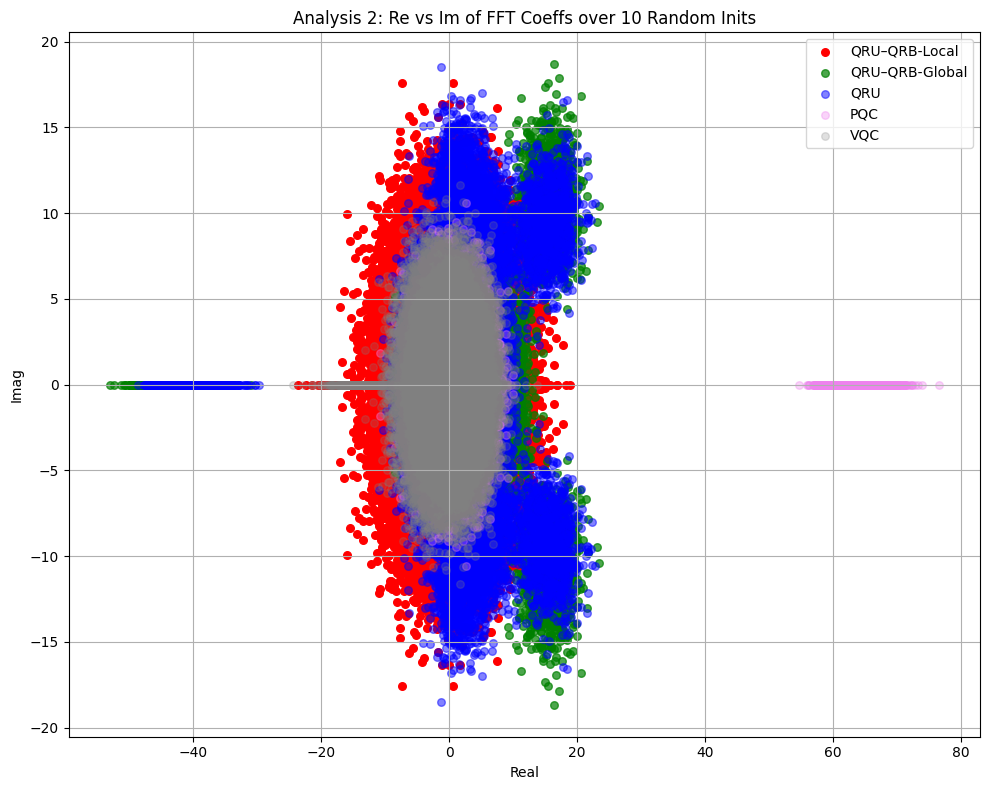

In [56]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_top_k_complex_combined(all_outputs, model_names, top_k=3, title="Top-K FFT Coeffs"):
    colors = ['red', 'green', 'blue', 'violet', 'grey']  # one for each model
    max_runs = max(len(runs) for runs in all_outputs)

    plt.figure(figsize=(10, 8))

    for model_idx, model_outputs in enumerate(np.flip(all_outputs)):
        color = colors[model_idx]
        for j, run_output in enumerate(model_outputs):
            run_output = torch.tensor(np.array(run_output).reshape(-1), dtype=torch.float32)
            fft_vals = torch.fft.fft(run_output)
            fft_mags = torch.abs(fft_vals)

            top_indices = torch.topk(fft_mags, top_k).indices
            reals = torch.real(fft_vals)
            imags = torch.imag(fft_vals)

            # Opacity decreases with each run to show overlap
            #alpha = 0.2 + 0.8 * (1 - j / max_runs)  # fade out later runs
            alpha = (0.7 ** model_idx)
            #alpha = 1.0
            plt.scatter(reals, imags, c=color, s=30, alpha=alpha, label=model_names[model_idx] if j == 0 else None)

    plt.title(title)
    plt.xlabel("Real")
    plt.ylabel("Imag")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("top_k_fft_coeffs_combined.png", dpi=300)
    plt.show()

# Plotting all outputs per model
plot_top_k_complex_combined(all_random_outputs,model_names, title="Analysis 2: Re vs Im of FFT Coeffs over 10 Random Inits")

## Quantum state distribution

Sampling for QRU-QRB-global:   0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-48-bf89c7283be3>:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float64).reshape(1, -1)
Sampling for QRU-QRB-global: 100%|██████████| 1000/1000 [1:43:37<00:00,  6.22s/it]


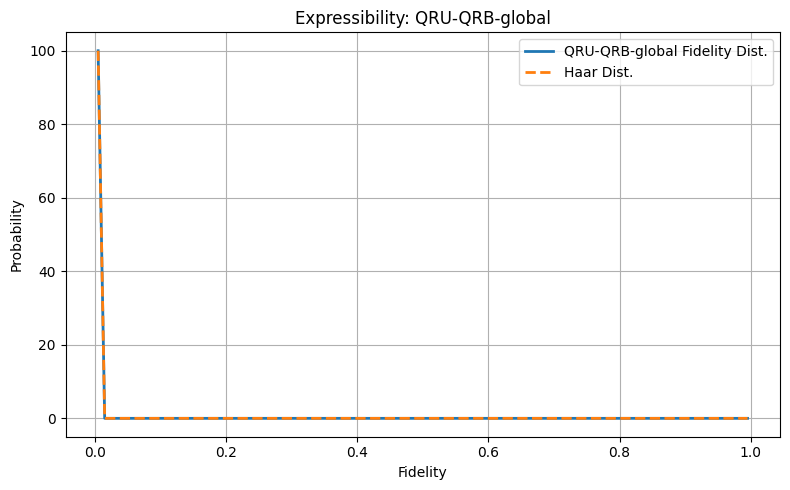

Sampling for QRU-QRB-local: 100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


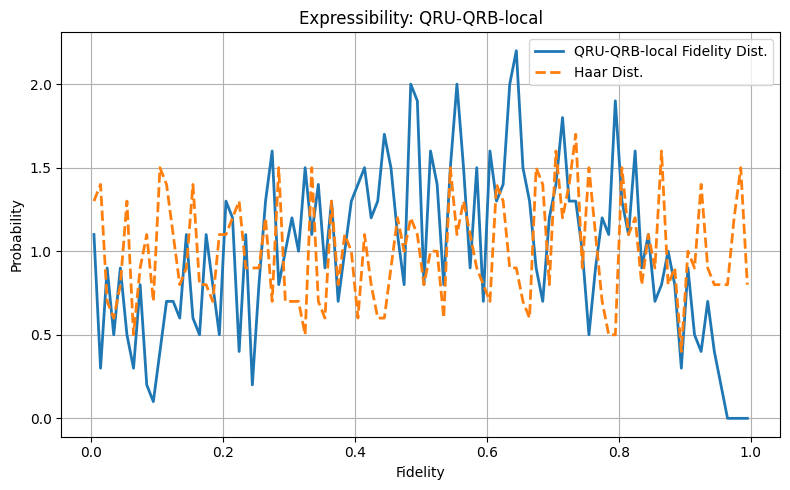

Sampling for QRU: 100%|██████████| 1000/1000 [00:49<00:00, 20.08it/s]


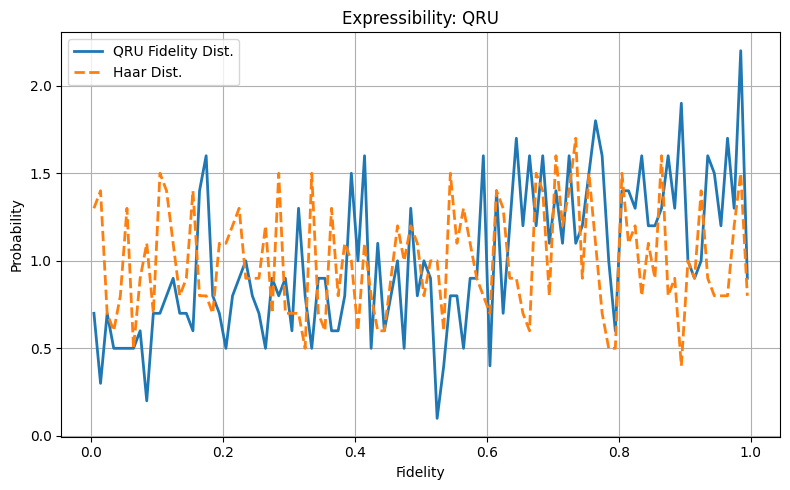

Sampling for PQC: 100%|██████████| 1000/1000 [00:35<00:00, 27.82it/s]


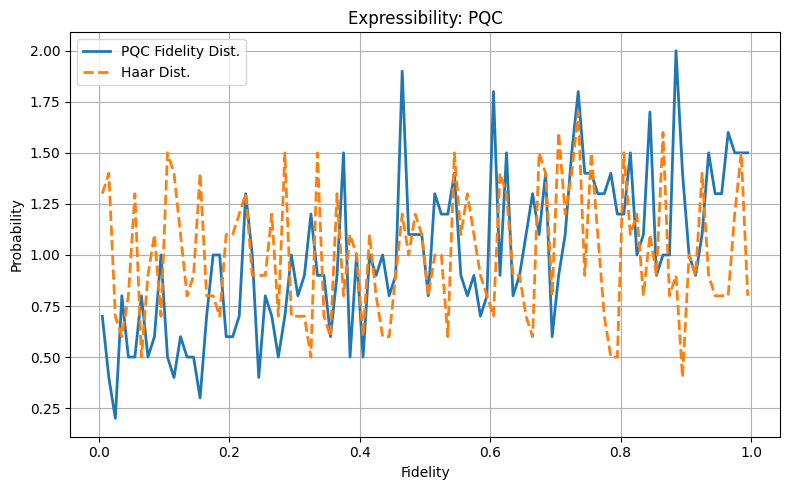

Sampling for VQC: 100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


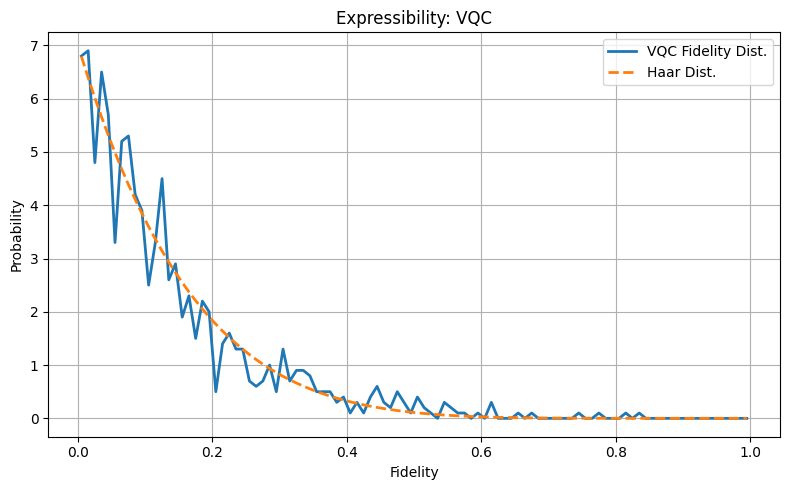


KL Divergences:
QRU: 0.13421
PQC: 0.12028
VQC: 0.07041
QRB_local: 0.20022
QRB_global: 0.00000


In [48]:
import torch
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm import tqdm

# ========== CONFIG ========== #
n_qubits = 1
n_input = 3
depth = 15
inp_vqc = 3
depth_vqc = 15
num_samples = 1000
num_bins = 100
circuit_depth = depth
n_ancillas = n_qubits * depth  # Multiple ancilla qubits
num_wires = n_qubits + n_ancillas  # Total number of wires
# ========== DEVICES ========== #
dev_qru = qml.device("default.qubit", wires=n_qubits)
dev_pqc = qml.device("default.qubit", wires=n_qubits)
dev_vqc = qml.device("default.qubit", wires=inp_vqc)
dev_qrb_local = qml.device("default.qubit", wires=2)
dev_global = qml.device("default.qubit", wires=num_wires)

# ========== CIRCUITS ========== #
def QRU(params, x, alpha=0.5):
    # The re-uploading circuit with 3 rotations per input per layer
    for i in range(depth):
        for j in range(len(x)):
            qml.RY(x[j], wires=0)
            qml.RX(params[i][2 * j], wires=0)
            qml.RY(params[i][2 * j + 1], wires=0)
            
    return qml.state()

@qml.qnode(dev_qru, interface="torch")
def circuit_qru(params, x):
    return QRU(params, x)

def PQC(params, x):
    for j in range(len(x)):
        qml.RY(x[j], wires=0)
    for i in range(depth):
        for j in range(len(x)):
            qml.RX(params[i][2 * j], wires=0)
            qml.RY(params[i][2 * j + 1], wires=0)
    return qml.state()

@qml.qnode(dev_pqc, interface="torch")
def circuit_pqc(params, x):
    return PQC(params, x)

def VQC(params,x):
    qml.templates.AngleEmbedding(x, wires=range(inp_vqc), rotation="Y")
    for i in range(depth_vqc):
        for j in range(inp_vqc):
            qml.RX(params[i][2 * j], wires=j)
        entangler_params = params[i][inp_vqc:].reshape(1, inp_vqc)
        qml.templates.BasicEntanglerLayers(entangler_params, wires=range(inp_vqc))
    return qml.state()

@qml.qnode(dev_vqc, interface="torch")
def circuit_vqc(params, x):
    return VQC(params,x)


def qrbGlobal_circuit(inputs, weights):
    
    for i in range(depth):
        ancilla_wire = n_qubits + (k * circuit_depth) + i

        # Apply controlled rotations using ancilla qubits
        qml.Rot(weights[0][k][i][0], weights[0][k][i][1], weights[0][k][i][2], wires=ancilla_wire)
        qml.Rot(weights[0][k][i][9], weights[0][k][i][10], weights[0][k][i][11], wires=k)
        x =inputs
        h =15
        for j in range(x.size(0)):
          qml.Rot(weights[0][k][i][h+j] * x[:,],weights[0][k][i][h+j+1] * x[:,],weights[0][k][i][h+j+2] * x[:,], wires=k)
        qml.CRot(weights[0][k][i][3] * x[:,], weights[0][k][i][4] * x[:,], weights[0][k][i][5] * x[:,], wires=[ancilla_wire, k])
        qml.Rot(weights[0][k][i][6], weights[0][k][i][7], weights[0][k][i][8], wires=k)
        qml.Rot(weights[0][k][i][12], weights[0][k][i][13], weights[0][k][i][14], wires=ancilla_wire)

    # # Multi-ancilla measurement scheme
    # proj = (qml.Identity(wires=n_qbits) + qml.PauliZ(wires=n_qbits)) / 2
    # for m in range(n_qbits+1, num_wires):
    #     proj = proj @ (qml.Identity(wires=m) + qml.PauliZ(wires=m)) / 2

    # dmeasure = qml.PauliZ(0)
    # for n in range(1, n_qbits):
    #     dmeasure = dmeasure @ qml.PauliZ(n)

    return qml.state()

class qrbGlobal(nn.Module):
    def __init__(self):
        super().__init__()        
        weight_shapes = {"weights": (1, n_qbits, circuit_depth, 18+12)}
        self.bias_real = nn.Parameter(torch.tensor(1.0, dtype=torch.float64), requires_grad=True)
        self.bias_imag = nn.Parameter(torch.tensor(1.0, dtype=torch.float64), requires_grad=True)

        self.lnn = nn.Sequential(nn.Linear(1, 1, dtype=torch.float64))
        self.dev = qml.device("default.qubit", wires=num_wires)
        
        # Wrap the quantum circuit in a QNode and then in a TorchLayer.
        @qml.qnode(self.dev, interface="torch")
        def qnode_circuit(inputs, weights):
            return qrbGlobal_circuit(inputs, weights)

        self.qlayer = TorchLayer(qnode_circuit, weight_shapes)

    def forward(self, x):        
        pass

qrb_global_model = QRB_global()
def qrb_circuit_global(params, x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float64).reshape(1, -1)
        qrb_global_model.qlayer.qnode.construct([x_tensor[0], params], {})  # set weights
        state = qrb_global_model.qlayer.qnode(x_tensor[0], params)
        return state

def qrbLocal(params, x, alpha=0.5):
    # Circuit avec re-uploading sur wire 0 et utilisation d'une seconde wire (wire 1)
    qml.Hadamard(wires=1)
    for i in range(depth):
        for j in range(len(x)):
            qml.RY(params[i][3 * j + 1] * x[j], wires=0)
        qml.CRX(alpha * params[i][3 * len(x) + 1], wires=[1, 0])    
        for j in range(len(x)):
            qml.RX(params[i][3 * j], wires=0)
            qml.RZ(params[i][3 * j + 2], wires=0)
    qml.Hadamard(wires=1)
    proj = (qml.Identity(wires=1) + qml.PauliZ(wires=1)) / 2
    return qml.state()

@qml.qnode(dev_qrb_local, interface="torch")
def circuitQrb_local(params, x):
    return qrbLocal(params, x)

# ========== METRIC COMPUTATION ========== #
def state_fidelity(psi1, psi2, model_name):
    if "global" in model_name:
        return qml.math.fidelity(psi1, psi2, check_state=False)
    else:
        return qml.math.fidelity(psi1, psi2, check_state=True)

def haar_distribution(N, num_bins=100):
    f_vals = np.linspace(0, 1, 10000)
    p_vals = (N - 1) * (1 - f_vals) ** (N - 2)
    p_vals /= np.trapz(p_vals, f_vals)  # Normalize by area, not sum
    hist, bin_edges = np.histogram(f_vals, bins=num_bins, weights=p_vals, density=True)
    return hist, bin_edges

def sample_haar_reference_distribution(num_samples=1000, num_bins=100):
    fidelities = []
    for _ in range(num_samples):
        U1 = sample_random_unitary()
        U2 = sample_random_unitary()
        psi1 = U1 @ np.array([1.0, 0.0])
        psi2 = U2 @ np.array([1.0, 0.0])
        psi1 =qml.math.dm_from_state_vector(psi1)
        psi2 =qml.math.dm_from_state_vector(psi2)
        fid = state_fidelity(psi1, psi2, "haar")
        fidelities.append(fid)
    
    hist, bin_edges = np.histogram(fidelities, bins=num_bins, range=(0, 1), density=True)
    return hist, bin_edges

def sample_random_unitary():
    # Generate a Haar-random unitary from U(2)
    Z = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
    Q, R = np.linalg.qr(Z)
    D = np.diag(R) / np.abs(np.diag(R))
    return Q @ np.diag(D)


def kl_expressibility(qnode, param_shape, x_input, n_wires, model_name, fixed_haar=None):
    fidelities = []
    for _ in tqdm(range(num_samples), desc=f"Sampling for {model_name}"):
        θ1 = torch.rand(param_shape, dtype=torch.float64)
        θ2 = torch.rand(param_shape, dtype=torch.float64)

        psi1 = qnode(θ1, x_input).detach().numpy()
        psi1 =qml.math.dm_from_state_vector(psi1)
        psi2 = qnode(θ2, x_input).detach().numpy()
        psi2 =qml.math.dm_from_state_vector(psi2)

        fid = state_fidelity(psi1, psi2, str(model_name))
        fidelities.append(fid)

    fidelities = np.array(fidelities)
    pf_hist, bins = np.histogram(fidelities, bins=num_bins, range=(0, 1), density=True)

    ph_hist = fixed_haar
    
    # # Use sample-based Haar distribution for 1-qubit models
    # if model_name in ["QRU", "PQC"] and n_wires == 1:
    #     ph_hist = fixed_haar
    # else:
    #     ph_hist, _ = haar_distribution(2 ** n_wires, num_bins)    

    eps = 1e-10
    pf_hist += eps
    ph_hist += eps

    kl = entropy(pf_hist, ph_hist)
    return kl, pf_hist, ph_hist, bins

# def kl_expressibility(qnode, param_shape, X_inputs, n_wires, model_name, num_bins=100):
#     fidelities = []
#     for _ in tqdm(range(num_samples), desc=f"Sampling for {model_name}"):
#         θ1 = torch.rand(param_shape, dtype=torch.float64)
#         θ2 = torch.rand(param_shape, dtype=torch.float64)

#         # Loop through multiple inputs
#         for x in X_inputs:
#             psi1 = qnode(θ1, x).detach().numpy()
#             psi2 = qnode(θ2, x).detach().numpy()

#             fid = state_fidelity(psi1, psi2)
#             fidelities.append(fid)

#     fidelities = np.array(fidelities)
#     pf_hist, bins = np.histogram(fidelities, bins=num_bins, range=(0, 1), density=True)
#     ph_hist, _ = haar_distribution(2 ** n_wires, num_bins)

#     eps = 1e-10
#     pf_hist += eps
#     ph_hist += eps

#     kl = entropy(pf_hist, ph_hist)
#     return kl, pf_hist, ph_hist, bins


# ========== PLOT ========== #
def plot_distributions(pf, ph, bins, name):
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.figure(figsize=(8, 5))
    plt.plot(bin_centers, pf, label=f"{name} Fidelity Dist.", lw=2)
    plt.plot(bin_centers, ph, label="Haar Dist.", linestyle="--", lw=2)
    plt.xlabel("Fidelity")
    plt.ylabel("Probability")
    plt.title(f"Expressibility: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"expressibility_{name.lower()}.png", dpi=300)
    plt.show()

def run_kl_trials(qnode, param_shape, x_input, n_wires, model_name, fixed_haar, n_trials=5):
    kl_vals = []
    for i in range(n_trials):
        print(f"\nTrial {i+1}/{n_trials} for {model_name}")
        kl, _, _, _ = kl_expressibility(qnode, param_shape, x_input, n_wires, model_name, fixed_haar=fixed_haar)
        kl_vals.append(kl)
    kl_avg = np.mean(kl_vals)
    kl_std = np.std(kl_vals)
    print(f"\nAverage KL Divergence for {model_name} over {n_trials} trials: {kl_avg:.5f} ± {kl_std:.5f}")
    return kl_avg, kl_std

# ========== RUN ========== #
if __name__ == "__main__":
    x_fixed = torch.tensor([0.1], dtype=torch.float64)
    #x_fixed = X_test

    fixed_haar, _ = sample_haar_reference_distribution(num_samples, num_bins)
    analytic_haar_vqc, _ = haar_distribution(2 ** inp_vqc, num_bins)
    analytic_haar_qrbg, _ = haar_distribution(2 ** num_wires, num_bins)

    # print("\n--- Running trials for KL Estimation ---")
    # run_kl_trials(circuit_qru, (depth, 2 * n_input), x_fixed, n_qubits, "QRU", fixed_haar)
    # run_kl_trials(circuit_pqc, (depth, 2 * n_input), x_fixed, n_qubits, "PQC", fixed_haar)
    # run_kl_trials(circuit_vqc, (depth_vqc, 2 * inp_vqc), x_fixed, inp_vqc, "HybridVQC", analytic_haar)    
    #run_kl_trials(circuit_qrb_local, (depth, 3 * n_input + 2), x_fixed, 2, "QRU–QRB-Local", fixed_haar)        
    #run_kl_trials(circuit_qrb_global, (1, n_qubits, depth, 30), x_fixed, num_wires, "QRU–QRB-Global", fixed_haar)

    # QRB_global
    param_shape_qrbg = (1, n_qubits, depth, 30)
    kl_qrbg, pf_qrbg, ph_qrbg, bins_qrbg = kl_expressibility(qrb_circuit_global, param_shape_qrbg, x_fixed, num_wires, "QRU-QRB-global", fixed_haar=analytic_haar_qrbg)
    plot_distributions( pf_qrbg, ph_qrbg, bins_qrbg, "QRU-QRB-global")
    
    # QRB_local
    param_shape_qrbl = (depth_vqc, 2 * inp_vqc)
    kl_qrbl, pf_qrbl, ph_qrbl, bins_qrbl = kl_expressibility(circuitQrb_local, param_shape_qrbl, x_fixed, 2, "QRU-QRB-local", fixed_haar=fixed_haar)
    plot_distributions(pf_qrbl, ph_qrbl, bins_qrbl, "QRU-QRB-local")
    
    # QRU
    param_shape_qru = (depth, 2 * n_input)
    kl_qru, pf_qru, ph_qru, bins_qru = kl_expressibility(circuit_qru, param_shape_qru, x_fixed, n_qubits, "QRU", fixed_haar=fixed_haar)
    plot_distributions(pf_qru, ph_qru, bins_qru, "QRU")

    # PQC
    param_shape_pqc = (depth, 2 * n_input)
    kl_pqc, pf_pqc, ph_pqc, bins_pqc = kl_expressibility(circuit_pqc, param_shape_pqc, x_fixed, n_qubits, "PQC", fixed_haar=fixed_haar)
    plot_distributions(pf_pqc, ph_pqc, bins_pqc, "PQC")

    # Hybrid VQC
    param_shape_vqc = (depth_vqc, 2 * inp_vqc)
    kl_vqc, pf_vqc, ph_vqc, bins_vqc = kl_expressibility(circuit_vqc, param_shape_vqc, x_fixed, inp_vqc, "VQC", fixed_haar=analytic_haar_vqc)
    plot_distributions(pf_vqc, ph_vqc, bins_vqc, "VQC")

    
    # Print all KLs
    print("\nKL Divergences:")
    print(f"QRU: {kl_qru:.5f}")
    print(f"PQC: {kl_pqc:.5f}")
    print(f"VQC: {kl_vqc:.5f}")
    print(f"QRB_local: {kl_qrbl:.5f}")
    print(f"QRB_global: {kl_qrbg:.5f}")
